In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv(r"C:\Users\Revathi\Documents\MLProjects\CreditCardFraudDetection\dataset\creditcard.csv")

In [4]:
df.shape

(284807, 31)

In [5]:
df.isnull().values.any()

False

C:\Users\Revathi\AppData\Local\Temp\ipykernel_10868\2107955042.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


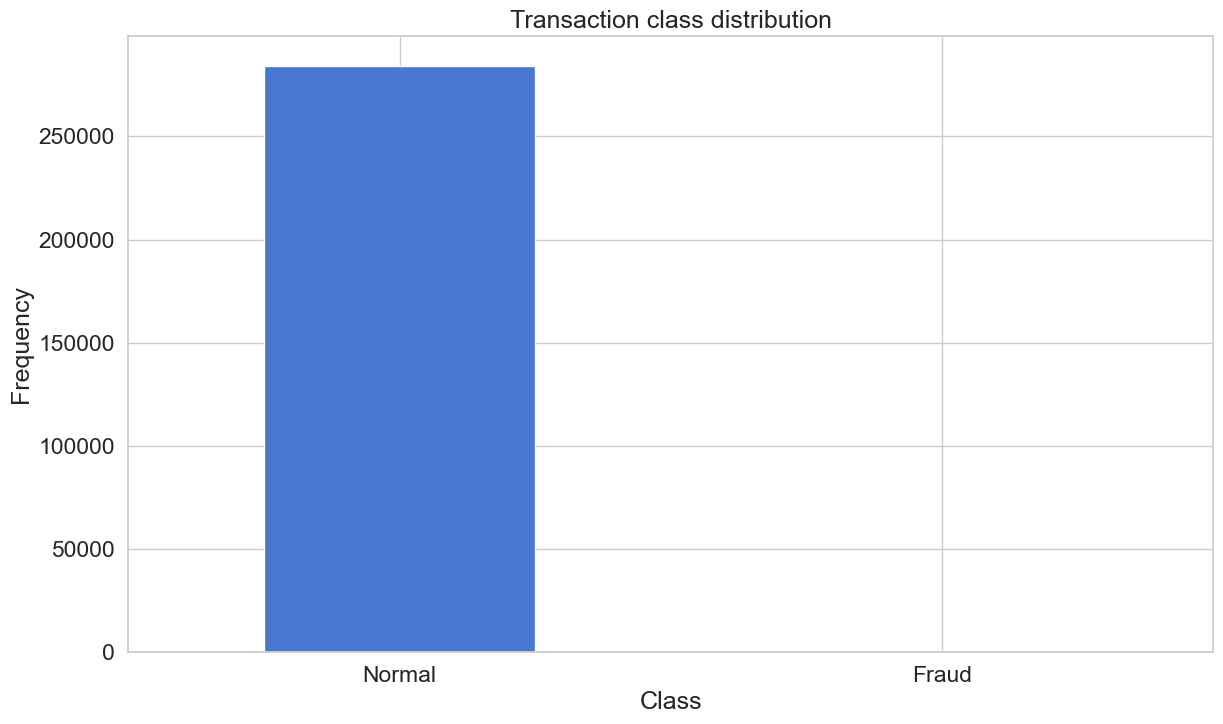

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [7]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [8]:
frauds.shape

(492, 31)

In [9]:
normal.shape

(284315, 31)

In [10]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [11]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

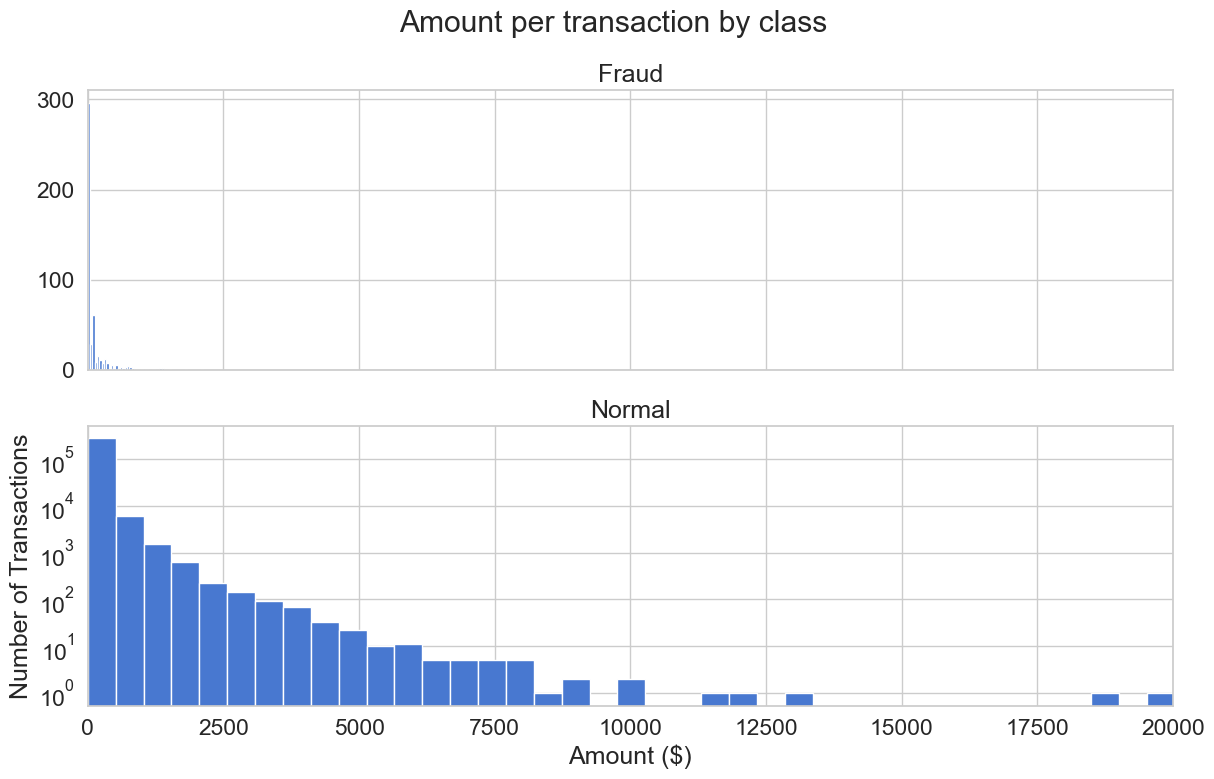

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

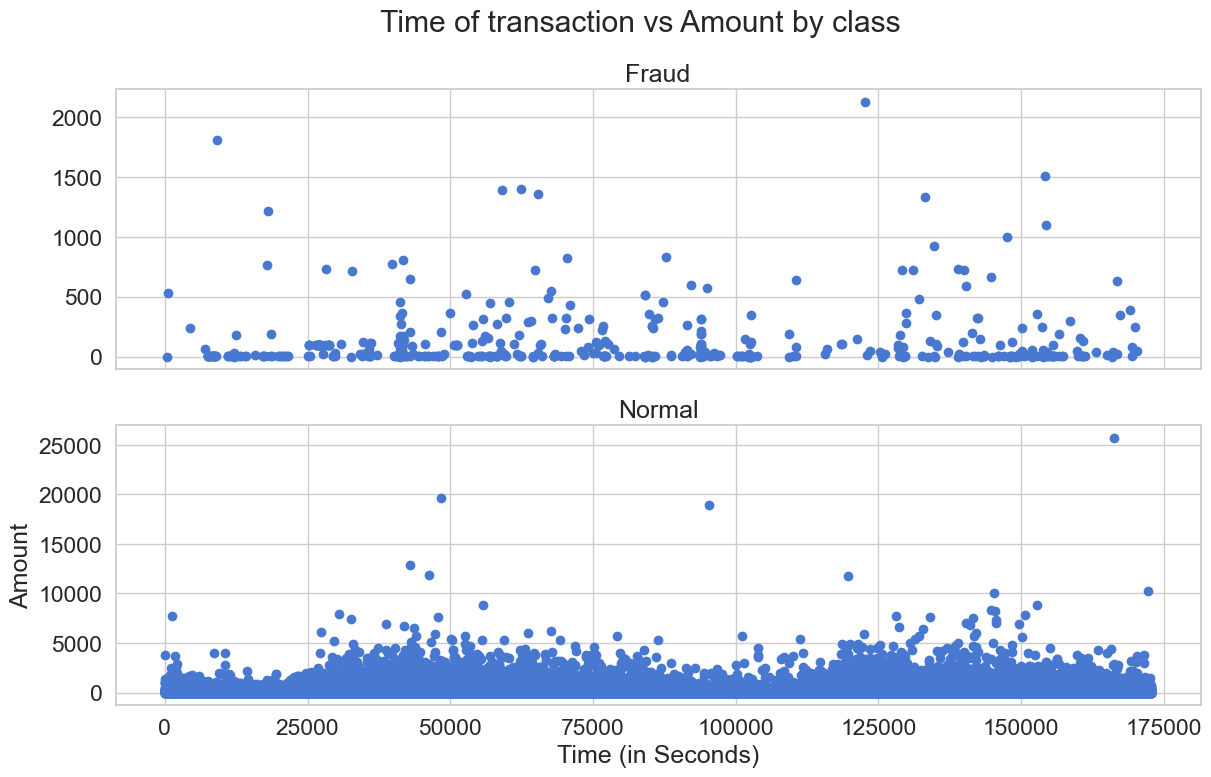

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [17]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [18]:
X_train.shape

(227451, 29)

Building the model
Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [19]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [20]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [23]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.keras",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.4968 - loss: 0.8578 - val_accuracy: 0.6569 - val_loss: 0.7897
Epoch 2/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.6579 - loss: 0.7585 - val_accuracy: 0.6577 - val_loss: 0.7772
Epoch 3/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.6640 - loss: 0.7464 - val_accuracy: 0.6652 - val_loss: 0.7688
Epoch 4/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.6677 - loss: 0.7266 - val_accuracy: 0.6712 - val_loss: 0.7619
Epoch 5/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.6739 - loss: 0.7249 - val_accuracy: 0.6768 - val_loss: 0.7579
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.6788 - loss: 0.7187 - val_accuracy: 0.6871 - val_loss: 0.7564
Epoch 7/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.6812 - loss: 0.7216 - val_accuracy: 0.6855 - val_loss: 0.7545
Epoch 8/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.6841 -

In [25]:
autoencoder = load_model('model.keras')

Evaluation

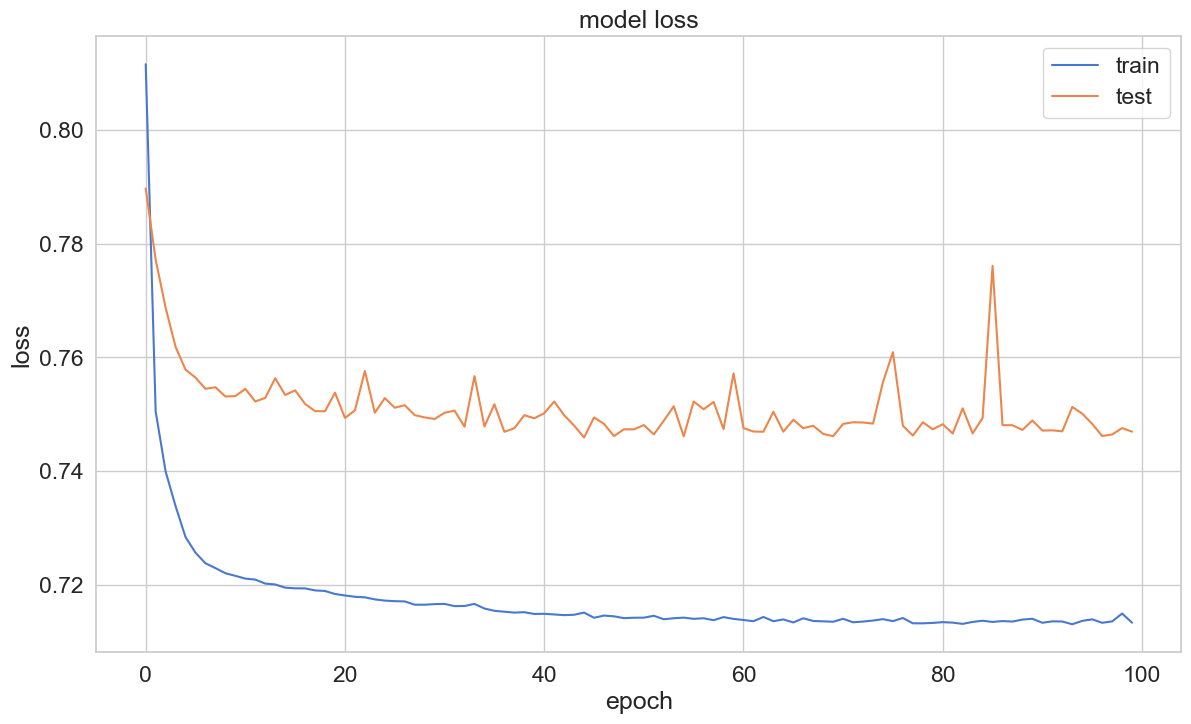

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [27]:
predictions = autoencoder.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [28]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [29]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.735920,0.001720
std,3.406977,0.041443
min,0.046872,0.000000
25%,0.241690,0.000000
50%,0.382755,0.000000
75%,0.616278,0.000000
max,265.104012,1.000000


Reconstruction error without fraud

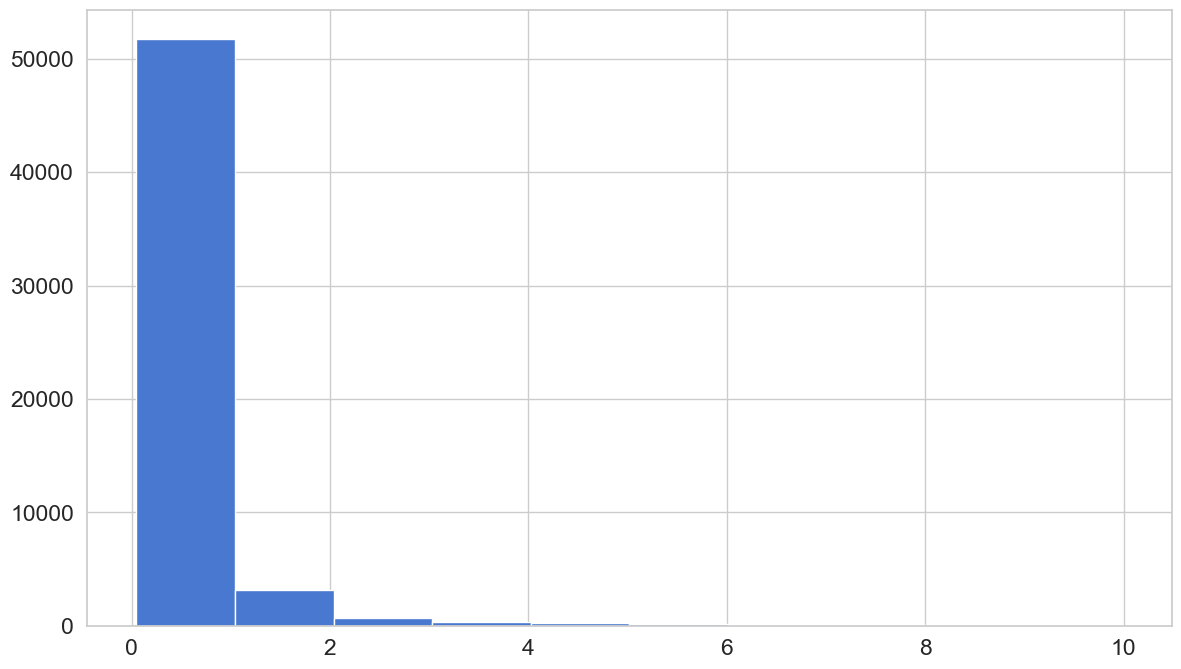

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

Reconstruction error with fraud

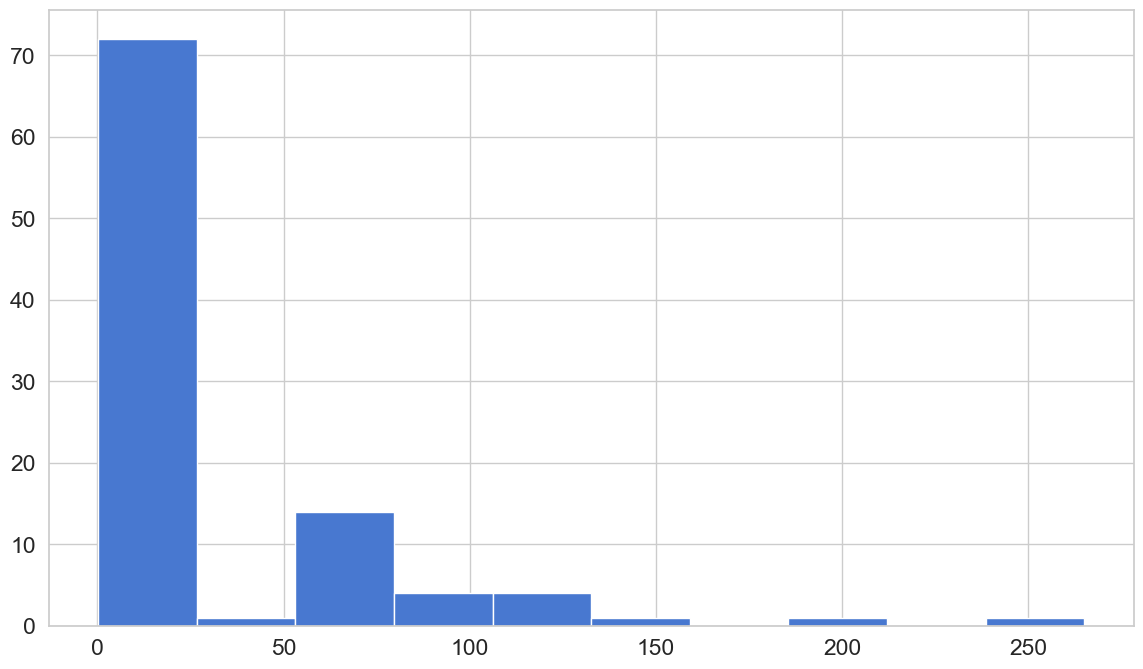

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [32]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

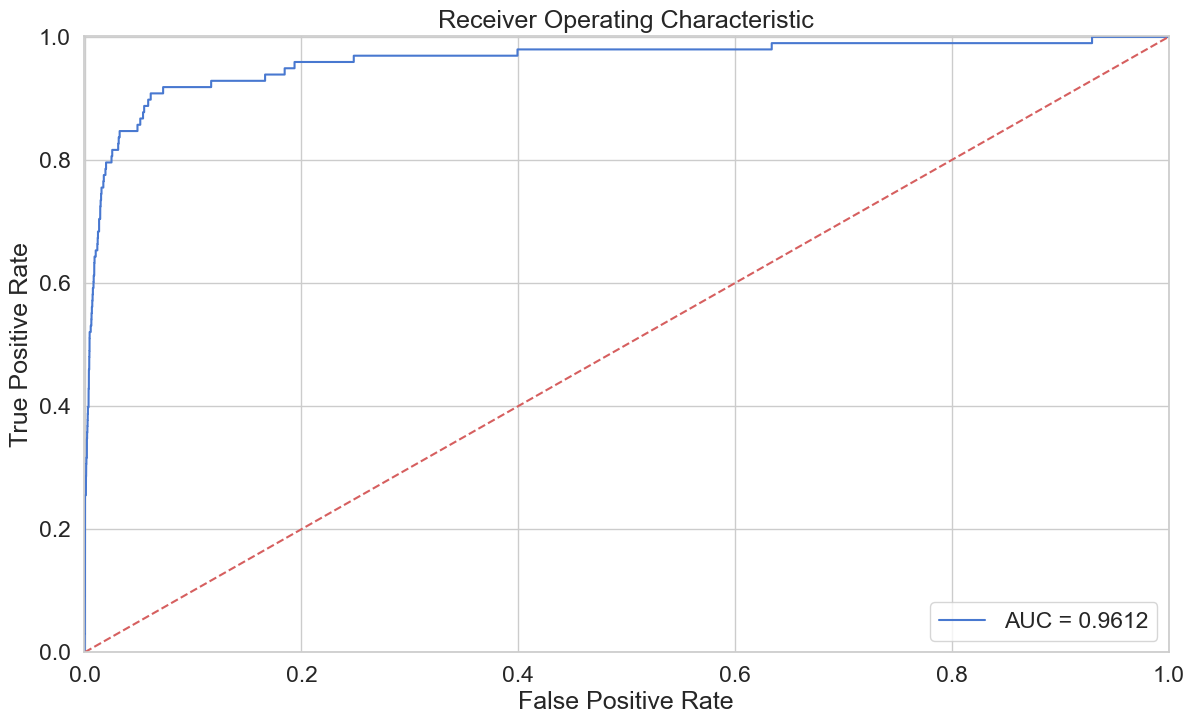

In [33]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

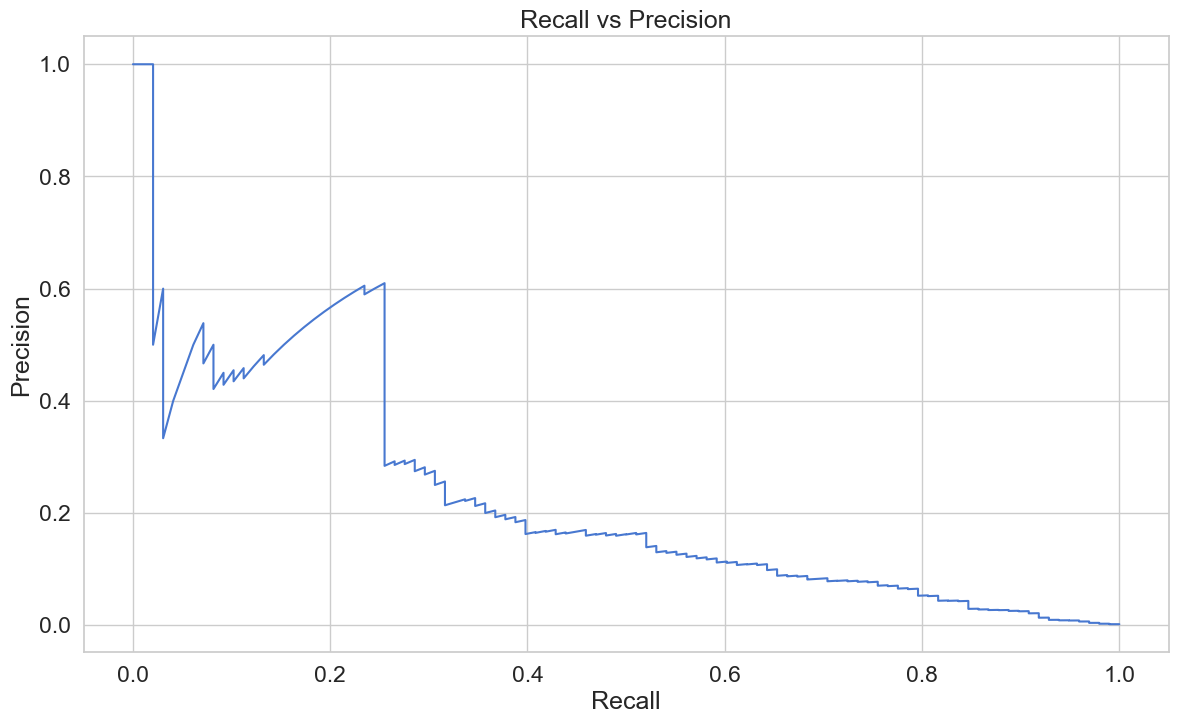

In [34]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

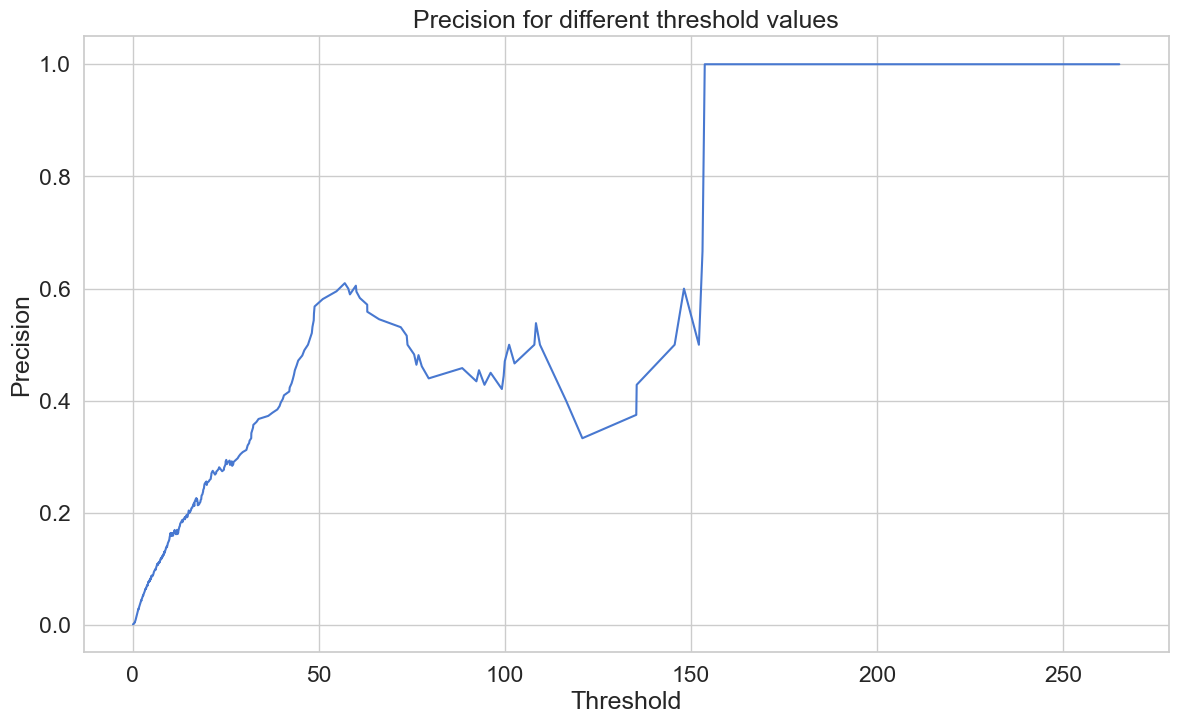

In [35]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

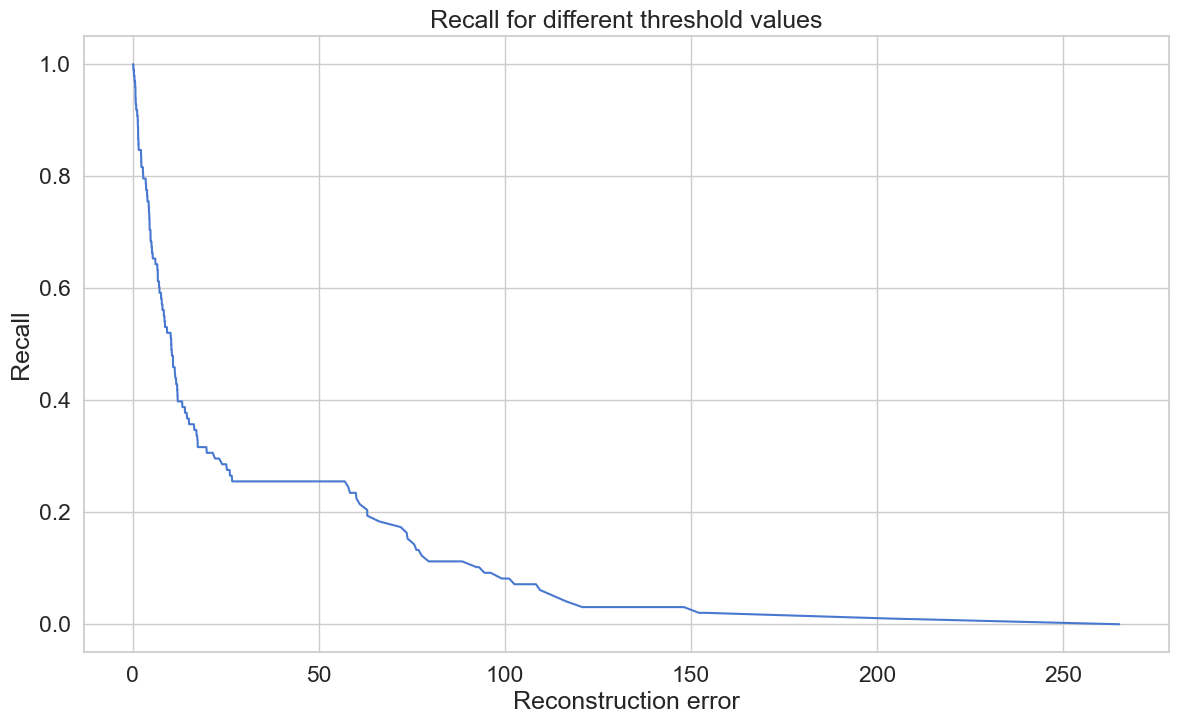

In [36]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [37]:
threshold = 2.9

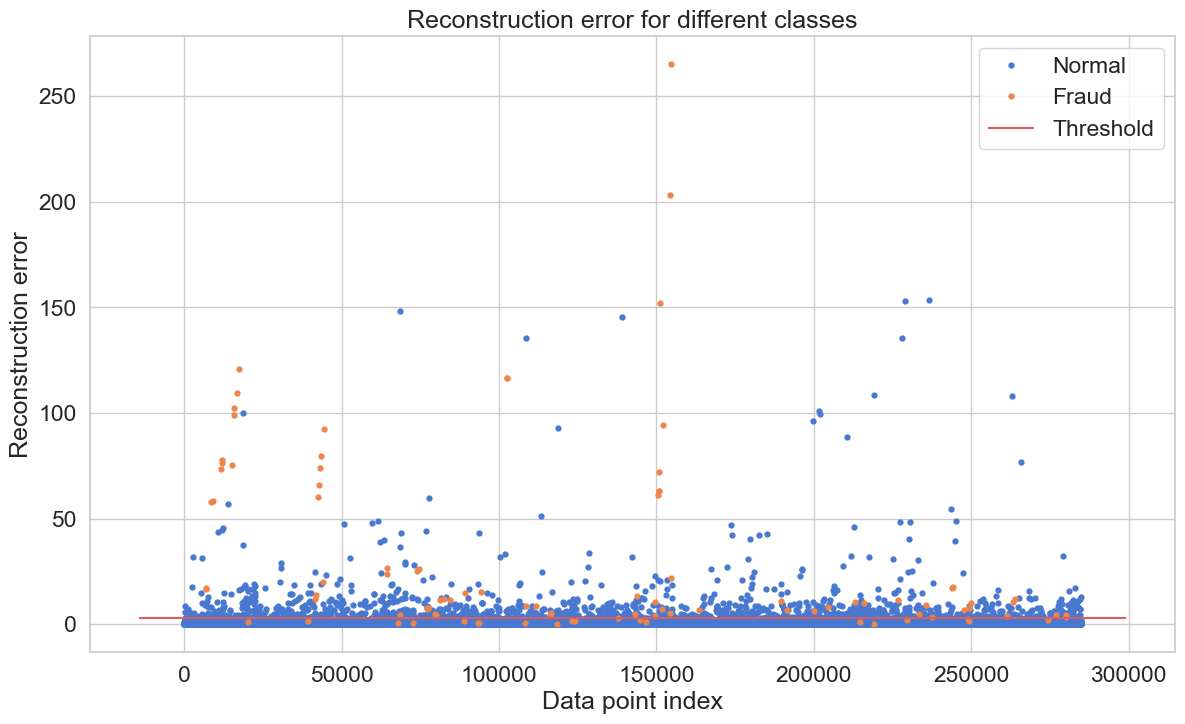

In [38]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

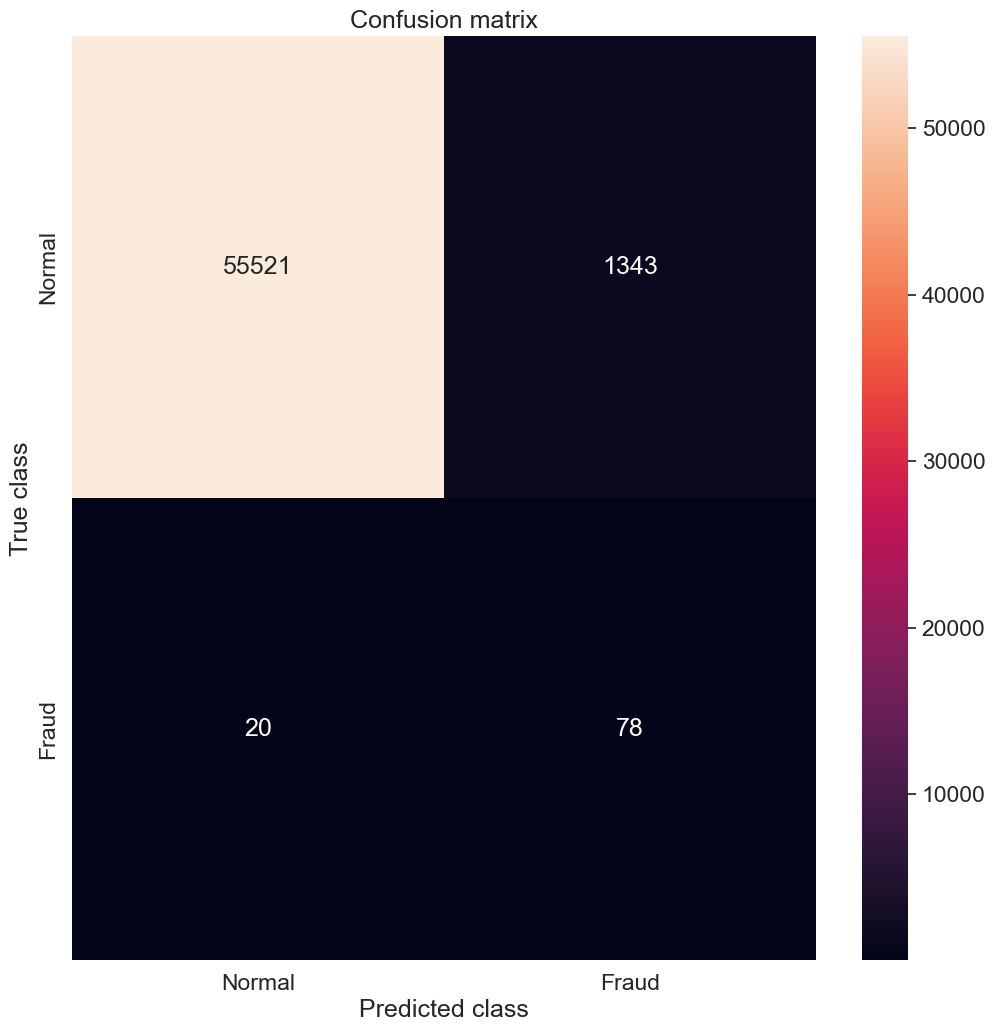

In [39]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show() 

In [ ]:
Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor # For anomaly detection, though less common for direct classification
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's pipeline for resampling steps

import warnings
warnings.filterwarnings('ignore')

# --- 1. Data Acquisition and Understanding (Simulated) ---
# In a real scenario, you'd load your data from a CSV, database, etc.
# For demonstration, we'll create a synthetic dataset that mimics real-world challenges (imbalance, some features).

print("1. Data Acquisition and Understanding (Simulated)")

def create_synthetic_data(num_transactions=100000, fraud_ratio=0.01):
    np.random.seed(42) # for reproducibility

    data = {
        'transaction_id': range(num_transactions),
        'user_id': np.random.randint(1, num_transactions // 10, num_transactions),
        'merchant_id': np.random.randint(1, num_transactions // 20, num_transactions),
        'amount': np.random.lognormal(mean=2.5, sigma=1.0, size=num_transactions).round(2), # Skewed distribution
        'time_in_seconds': np.random.randint(0, 24 * 3600 * 30, num_transactions), # Over 30 days
        'location_lat': np.random.uniform(0, 90, num_transactions),
        'location_lon': np.random.uniform(0, 180, num_transactions),
        'transaction_type': np.random.choice(['online', 'pos', 'atm', 'international'], num_transactions, p=[0.5, 0.3, 0.1, 0.1]),
        'is_fraud': np.zeros(num_transactions, dtype=int)
    }
    df = pd.DataFrame(data)

    # Introduce some fraud cases
    num_fraud = int(num_transactions * fraud_ratio)
    fraud_indices = np.random.choice(num_transactions, num_fraud, replace=False)
    df.loc[fraud_indices, 'is_fraud'] = 1

    # Make fraud transactions slightly different
    df.loc[fraud_indices, 'amount'] = df.loc[fraud_indices, 'amount'] * np.random.uniform(1.5, 5.0, num_fraud) # Higher amounts
    df.loc[fraud_indices, 'time_in_seconds'] = df.loc[fraud_indices, 'time_in_seconds'] + np.random.randint(0, 3600, num_fraud) # Slightly different times
    df.loc[fraud_indices, 'transaction_type'] = np.random.choice(['international', 'online'], num_fraud, p=[0.7, 0.3]) # More international/online fraud

    # Introduce some missing values to demonstrate imputation
    missing_amount_indices = np.random.choice(num_transactions, int(num_transactions * 0.005), replace=False)
    df.loc[missing_amount_indices, 'amount'] = np.nan

    return df

df = create_synthetic_data(num_transactions=100000, fraud_ratio=0.005)
print(f"Dataset shape: {df.shape}")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nMissing values before imputation:")
print(df.isnull().sum())
print("\nFraudulent transactions distribution:")
print(df['is_fraud'].value_counts(normalize=True))
print("-" * 50)

# --- 2. Data Preprocessing ---
print("2. Data Preprocessing")

# Handle Missing Values
# For numerical 'amount', we'll use mean imputation. For categorical, mode.
imputer_numerical = SimpleImputer(strategy='mean')
df['amount'] = imputer_numerical.fit_transform(df[['amount']])

print("\nMissing values after imputation:")
print(df.isnull().sum())

# Feature Engineering - Time-based features
# Convert 'time_in_seconds' to more meaningful features
df['hour'] = (df['time_in_seconds'] // 3600) % 24
df['day_of_week'] = (df['time_in_seconds'] // (3600 * 24)) % 7 # 0 for first day, 6 for last

# Binning 'amount' might be useful for some models, or for creating interaction terms.
# For simplicity, we'll keep it numerical for now but scale it.

# Encoding Categorical Features
# 'transaction_type' needs to be converted to numerical. One-Hot Encoding is suitable.
df = pd.get_dummies(df, columns=['transaction_type'], drop_first=True)

# 'user_id' and 'merchant_id' are high cardinality.
# For simplicity, we'll treat them as numerical, but in a real scenario,
# you might use target encoding, embedding, or aggregate features based on them.
# For now, just scaling them.

# Drop original 'time_in_seconds' and 'transaction_id' (not features for the model)
df = df.drop(columns=['time_in_seconds', 'transaction_id'])

# Separate features (X) and target (y)
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split data into training and testing sets
# Use stratify to maintain the same fraud ratio in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nShape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")
print("-" * 50)

# --- 3. Exploratory Data Analysis (EDA) ---
# This is usually done before preprocessing, but some insights come post-preprocessing
print("3. Exploratory Data Analysis (Conceptual)")
# Due to the non-interactive nature of this environment, I'll describe EDA steps.
# In a real notebook, you'd perform the following:

# Visualize the distribution of 'amount'
# plt.figure(figsize=(10, 6))
# sns.histplot(df['amount'], bins=50, kde=True)
# plt.title('Distribution of Transaction Amount')
# plt.show()

# Compare 'amount' for fraud vs. non-fraud
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='is_fraud', y='amount', data=df)
# plt.title('Transaction Amount by Fraud Status')
# plt.ylim(0, df['amount'].quantile(0.99)) # To avoid outliers dominating the view
# plt.show()

# Time-based analysis (e.g., fraud by hour of day)
# plt.figure(figsize=(10, 6))
# sns.countplot(x='hour', hue='is_fraud', data=df)
# plt.title('Fraud vs. Non-Fraud by Hour of Day')
# plt.show()

# Correlation matrix
# plt.figure(figsize=(12, 10))
# sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
# plt.title('Correlation Matrix of Features')
# plt.show()

print("   EDA steps typically involve visualizing distributions, correlations, and differences between fraud/non-fraud classes.")
print("   This helps in understanding the data and guiding feature engineering.")
print("-" * 50)

# --- 4. Feature Engineering (Additional Conceptual) ---
print("4. Feature Engineering (Conceptual)")
# We already created 'hour' and 'day_of_week'. More advanced features could include:
# - Aggregated features per user: average transaction amount for a user, number of transactions in last N hours/days,
#   number of unique merchants, velocity features (transactions per unit time).
# - Location-based features: distance from usual transaction location, entropy of locations.
# - Time-between-transactions for a user.
# - Interaction features: e.g., amount * is_international
print("   More advanced feature engineering would involve creating aggregate features (e.g., per user, per merchant),")
print("   velocity features (transactions per hour/day), and potentially geographic features.")
print("-" * 50)

# --- 5. Model Selection ---
print("5. Model Selection")
# Common choices for fraud detection given imbalanced data:
# - Logistic Regression (good baseline, interpretable)
# - Random Forest (handles non-linearity, feature importance)
# - Gradient Boosting (XGBoost, LightGBM - often top performers)
# - SVM (can be good but slow on large datasets)
# - Neural Networks (deep learning approaches for very complex patterns)

# For this example, we'll use Logistic Regression and Random Forest as common choices.
# We also need to handle class imbalance. SMOTE (Synthetic Minority Over-sampling Technique)
# and RandomUnderSampler are common strategies.

# Define models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
}
print("   Selected models: Logistic Regression, Random Forest.")
print("   Class imbalance will be addressed using resampling techniques within a pipeline.")
print("-" * 50)

# --- 6. Model Training & 7. Model Evaluation (with handling imbalance) ---
print("6. Model Training & 7. Model Evaluation")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistent column names, though not strictly necessary for scikit-learn
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Define a pipeline to handle resampling and modeling
# This ensures resampling is only applied to the training data in each fold of CV
# and also to the full training set before final model training.
for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")

    # Pipeline with SMOTE for oversampling the minority class
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Train the pipeline
    pipeline.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test_scaled)
    y_pred_proba = pipeline.predict_proba(X_test_scaled)[:, 1] # Probability of the positive class

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title(f'Confusion Matrix for {name}')
    # plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    # plt.figure(figsize=(6, 4))
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'Receiver Operating Characteristic for {name}')
    # plt.legend(loc="lower right")
    # plt.show()

    # Precision-Recall Curve (often more informative for imbalanced datasets)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    # plt.figure(figsize=(6, 4))
    # plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.title(f'Precision-Recall Curve for {name}')
    # plt.legend(loc="lower left")
    # plt.show()

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    print("-" * 50)

# --- 8. Hyperparameter Tuning (Conceptual) ---
print("8. Hyperparameter Tuning (Conceptual)")
# This would typically involve techniques like GridSearchCV or RandomizedSearchCV
# within the pipeline to find the best hyperparameters for the chosen model.
# Example for Random Forest:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'classifier__n_estimators': [50, 100, 200],
#     'classifier__max_depth': [5, 10, None],
#     'smote__k_neighbors': [3, 5, 7] # Hyperparameter for SMOTE
# }
# grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(5), scoring='f1', n_jobs=-1, verbose=1)
# grid_search.fit(X_train_scaled, y_train)
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best cross-validation F1 score: {grid_search.best_score_}")

print("   Hyperparameter tuning would use GridSearchCV or RandomizedSearchCV to optimize model parameters,")
print("   often focusing on metrics like F1-score or Average Precision Score for imbalanced datasets.")
print("-" * 50)

# --- 9. Deployment (Conceptual) ---
print("9. Deployment (Conceptual)")
# Once a model is trained and validated, it needs to be deployed to make real-time predictions.
# This could involve:
# - Saving the model (e.g., using `joblib` or `pickle`).
# - Creating an API endpoint (e.g., using Flask, FastAPI) that receives transaction data and returns a fraud prediction.
# - Integrating with existing systems for real-time scoring.
# - Setting up thresholds for flagging transactions (e.g., if fraud probability > 0.5, flag).
# - Human review queue for flagged transactions.

# Example: Saving the best model
# import joblib
# joblib.dump(pipeline, 'fraud_detection_model.pkl')
# print("   Model saved to 'fraud_detection_model.pkl'")
print("   Deployment involves saving the trained model and integrating it into a real-time prediction system.")
print("   This often uses an API to receive transaction data and return fraud scores.")
print("-" * 50)

# --- 10. Monitoring and Re-training (Conceptual) ---
print("10. Monitoring and Re-training (Conceptual)")
# Fraud patterns evolve, so models degrade over time (concept drift).
# - **Performance Monitoring:** Continuously track model performance (precision, recall, AUC) on new, unseen data.
# - **Data Drift Detection:** Monitor changes in input data distributions.
# - **Feedback Loop:** Collect feedback from human reviewers on flagged transactions to improve labels.
# - **Regular Retraining:** Retrain the model periodically with new, labeled data to adapt to evolving fraud patterns.
# - **A/B Testing:** Test new models against the old in production before full rollout.

print("   Continuous monitoring of model performance and data drift is crucial.")
print("   Regular retraining with new, labeled data helps the model adapt to evolving fraud patterns.")
print("-" * 50)

print("\nFraud Detection Pipeline Complete!")

1. Data Acquisition and Understanding (Simulated)
Dataset shape: (100000, 9)
   transaction_id  user_id  merchant_id  amount  time_in_seconds  \
0               0     7271          312    6.33           103954   
1               1      861         4453    3.31           890092   
2               2     5391         1178    7.84           430271   
3               3     5192         3357   14.21          2523947   
4               4     5735         1699    2.99           305672   

   location_lat  location_lon transaction_type  is_fraud  
0     74.538048     80.175583              pos         0  
1      0.380156     89.271247    international         0  
2     54.187606     10.680192           online         0  
3     24.625531    153.710659    international         0  
4     24.625799     44.442214           online         0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column            Non-Null Coun

In [2]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable

   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalan